In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.layers import Flatten, Convolution2D, MaxPooling2D
from keras.models import load_model
from keras import models, layers
import tensorflow as tf
import cv2
import numpy as np

In [ ]:
PATH_tablet = '../gdrive/MyDrive/공모전용/HW-OCR/4.Validaiton/tablet/R.Free/전처리/'

In [ ]:
X_train, X_test, Y_train, Y_test = np.load('../gdrive/MyDrive/공모전용/HW-OCR/data_1.npy', allow_pickle = True)

In [ ]:
X_train = X_train.reshape((142719, 48, 48, 1))
X_test = X_test.reshape((47574, 48, 48, 1))

In [ ]:
Y_train = Y_train.reshape((142719, 968, 1))
Y_test = Y_test.reshape((47574, 968, 1))

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [ ]:
import tensorflow
from tensorflow.keras.activations import gelu
import tensorflow_addons as tfa
from typing import List, Tuple
 
###############################################
############ 멀티 헤드 어텐션 정의 ##############
###############################################
 
class MultiHeadedAttention(tensorflow.keras.Model):
    def __init__(self, dimension: int, heads: int = 8):
        super(MultiHeadedAttention, self).__init__()
        self.heads = heads
        self.dimension = dimension
        assert dimension // heads
        self.depth = dimension // heads
        self.wq = tensorflow.keras.layers.Dense(dimension)
        self.wk = tensorflow.keras.layers.Dense(dimension)
        self.wv = tensorflow.keras.layers.Dense(dimension)
        self.dense = tensorflow.keras.layers.Dense(dimension)
 
    def call(self, inputs):
        output = None
        batch_size = tensorflow.shape(inputs)[0]
        q: tensorflow.Tensor = self.wq(inputs)
        k: tensorflow.Tensor = self.wk(inputs)
        v: tensorflow.Tensor = self.wv(inputs)
 
        def split_heads(x, batch_size):
            x = tensorflow.reshape(x, (batch_size, -1, self.heads, self.depth))
            return tensorflow.transpose(x, perm=[0,2,1,3])
 
        q = split_heads(q, batch_size)
        k = split_heads(k, batch_size)
        v = split_heads(v, batch_size)
 
        def scaled_dot_product_attention(q,k,v):
            matmul_qk = tensorflow.matmul(q, k, transpose_b = True)
            dk = tensorflow.cast(tensorflow.shape(k)[-1], tensorflow.float32)
            scaled_attention_logits = matmul_qk / tensorflow.math.sqrt(dk)
 
            softmax = tensorflow.nn.softmax(scaled_attention_logits, axis=-1)
            scaled_dot_product_attention_output = tensorflow.matmul(softmax, v)
            return scaled_dot_product_attention_output, softmax
        
        attention_weights, softmax = scaled_dot_product_attention(q, k, v)
        scaled_attention = tensorflow.transpose(attention_weights, perm=[0,2,1,3])
        concat_attention = tensorflow.reshape(scaled_attention, (batch_size, -1, self.dimension))
        output = self.dense(concat_attention)
        return output
 
###############################################
############ 레지듀얼 블록 정의 ################
###############################################
 
class ResidualBlock(tensorflow.keras.Model):
    def __init__(self, residual_function):
        super(ResidualBlock, self).__init__()
        self.residual_function = residual_function
 
    def call(self, inputs):
        return self.residual_function(inputs) + inputs
 
###############################################
######## LayerNormalization 정의 ##############
###############################################
 
class NormalizationBlock(tensorflow.keras.Model):
    def __init__(self, norm_function, epsilon=1e-5):
        super(NormalizationBlock, self).__init__()
        self.norm_function = norm_function
        self.normalize = tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
 
    def call(self, inputs):
        return self.norm_function(self.normalize(inputs))
 
###############################################
############### MLP 블록 정의 #################
###############################################
 
class MLPBlock(tensorflow.keras.Model):
    def __init__(self, output_dimension, hidden_dimension):
        super(MLPBlock, self).__init__()
        self.output_dimension = tensorflow.keras.layers.Dense(output_dimension)
        self.hidden_dimension = tensorflow.keras.layers.Dense(hidden_dimension)
        self.dropout1 = tensorflow.keras.layers.Dropout(0.1)
        self.dropout2 = tensorflow.keras.layers.Dropout(0.1)
 
    def call(self, inputs):
        output = None
        x = self.hidden_dimension(inputs)
        x = gelu(x)
        x = self.dropout1(x)
        x = self.output_dimension(x)
        x = gelu(x)
        output = self.dropout2(x)
        return output
 
 
 
###############################################
############ 트랜스포머 인코더 정의 #############
###############################################
 
class TransformerEncoder(tensorflow.keras.layers.Layer):
    def __init__(self, dimension, depth, heads, mlp_dimension): 
        super(TransformerEncoder, self).__init__()
        layers_ = []
        layers_.append(tensorflow.keras.Input(shape=((CFG.obj_image_size//CFG.patch_size)*(CFG.obj_image_size//CFG.patch_size)+1,dimension)))
        for i in range(depth):
            layers_.append(NormalizationBlock(ResidualBlock(MultiHeadedAttention(dimension, heads))))
            layers_.append(NormalizationBlock(ResidualBlock(MLPBlock(dimension, mlp_dimension))))
        
        self.layers_ = tensorflow.keras.Sequential(layers_)
 
    def call(self, inputs):
        return self.layers_(inputs)
 
###############################################
############### VIT 전체 구현 #################
###############################################
 
class ImageTransformer(tensorflow.keras.Model):
    def __init__(
            self, image_size, patch_size, n_classes, batch_size,
            dimension, depth, heads, mlp_dimension, channels=3):
        super(ImageTransformer, self).__init__()
        assert image_size % patch_size == 0, 'invalid patch size for image size'
 
        num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size
        self.dimension = dimension
        self.batch_size = batch_size
 
        self.positional_embedding = self.add_weight(
            "position_embeddings", shape=[num_patches + 1, dimension],
            initializer=tensorflow.keras.initializers.RandomNormal(), dtype=tensorflow.float32
        )
        self.classification_token = self.add_weight(
            "classification_token", shape=[1, 1, dimension],
            initializer=tensorflow.keras.initializers.RandomNormal(), dtype=tensorflow.float32
        )
        self.heads = heads
        self.depth = depth
        self.mlp_dimension = dimension
        self.n_classes = n_classes
        self.num_patches = num_patches
 
        self.patch_projection = tensorflow.keras.layers.Dense(dimension)
        self.normalization2 = tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
        self.MLP = MLPBlock(self.dimension, self.mlp_dimension)
        self.output_classes = tensorflow.keras.layers.Dense(self.n_classes)
        self.transformer = TransformerEncoder(self.dimension, self.depth, self.heads, self.mlp_dimension)
        self.dropout1 = tensorflow.keras.layers.Dropout(0.5)
 
    def call(self, inputs):       
        output = None
        batch_size = tensorflow.shape(inputs)[0]
        
        ###############################################
        ############ 가장 중요한 부분 ##################
        ###############################################
 
        # 이미지를 patch_size로 조각낸다.
        patches = tensorflow.image.extract_patches(
            images = inputs,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1,1,1,1],
            padding="VALID",
        )
 
        patch_dims = patches.shape[-1]
        patches = tensorflow.reshape(patches, [batch_size, patches.shape[1]*patches.shape[2], patch_dims])
        x = self.patch_projection(patches)
        
        cls_pos = tensorflow.broadcast_to(
            self.classification_token, [batch_size, 1, self.dimension]
        )
        x = tensorflow.concat([cls_pos, x], axis=1)
        x = x + self.positional_embedding
        x = self.transformer(x)
        x = self.normalization2(x)
        x = x[:,0,:]
        x_keep = tensorflow.identity(x)
        x = self.dropout1(x)
        output = self.output_classes(x)
        return output

In [ ]:
class CFG:
    num_classes = 968
    input_shape = (48, 48, 1)
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 32
    num_epochs = 20
    image_size = 48
    obj_image_size = 48
    patch_size = 3
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 8
    transformer_layers = 3

In [ ]:
CFG = CFG()

In [ ]:
with tf.device('/device:GPU:0'):
  optimizer = tfa.optimizers.AdamW(learning_rate = CFG.learning_rate, weight_decay=CFG.weight_decay)
 
  model_vit = ImageTransformer(CFG.image_size, CFG.patch_size, CFG.num_classes, CFG.batch_size, CFG.projection_dim, CFG.transformer_layers, CFG.num_heads, CFG.projection_dim)
  model_vit.compile(
          optimizer=optimizer,
          loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=[tensorflow.keras.metrics.CategoricalAccuracy(name="accuracy")])
 
  hist = model_vit.fit(x=X_train, y=Y_train, batch_size=CFG.batch_size, epochs=CFG.num_epochs, validation_split=0.2, shuffle=True)
  print('==============Training Finished===============')

Epoch 1/20
3568/3568 [==============================] - 142s 38ms/step - loss: 4.9711 - accuracy: 0.0829 - val_loss: 3.9042 - val_accuracy: 0.1723
Epoch 2/20
3568/3568 [==============================] - 132s 37ms/step - loss: 3.3746 - accuracy: 0.2748 - val_loss: 2.3210 - val_accuracy: 0.4686
Epoch 3/20
3568/3568 [==============================] - 132s 37ms/step - loss: 2.2439 - accuracy: 0.4888 - val_loss: 1.5214 - val_accuracy: 0.6404
Epoch 4/20
3568/3568 [==============================] - 132s 37ms/step - loss: 1.7075 - accuracy: 0.5982 - val_loss: 1.1347 - val_accuracy: 0.7230
Epoch 5/20
3568/3568 [==============================] - 132s 37ms/step - loss: 1.4586 - accuracy: 0.6541 - val_loss: 0.9706 - val_accuracy: 0.7606
Epoch 6/20
3568/3568 [==============================] - 132s 37ms/step - loss: 1.3224 - accuracy: 0.6841 - val_loss: 0.8632 - val_accuracy: 0.7879
Epoch 7/20
3568/3568 [==============================] - 132s 37ms/step - loss: 1.2290 - accuracy: 0.7053 - val_loss: 0

In [ ]:
model_vit.save('../gdrive/MyDrive/공모전용/HW-OCR/VIT_model.h5', save_format='h5')

NotImplementedError: ignored

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
Y_test = np.argmax((Y_test), axis=1)
y_pred = hist.predict_classes(X_test)
result = classification_report(Y_test, y_pred)
print(result)

AttributeError: ignored

In [ ]:
accuracy = 0
_, accuracy = model_vit.evaluate(X_test, Y_test)
 
print('Test Accuracy :', accuracy)


1487/1487 [==============================] - 24s 16ms/step - loss: 0.5919 - accuracy: 0.8538
Test Accuracy : 0.8538066744804382


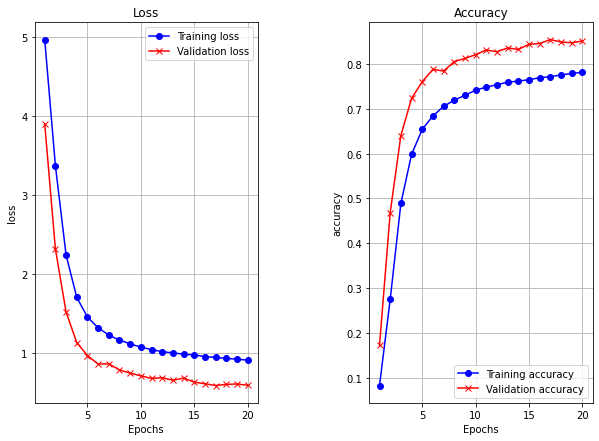

In [ ]:
import matplotlib.pyplot as plt
loss = hist.history['loss']
acc = hist.history['accuracy']
val_loss = hist.history['val_loss']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.figure(figsize=(10,7))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rx-', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'rx-', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.grid()
plt.legend()